In [2]:
# Data Wrangling
# MBA em Data Science e Analytics USP/ESALQ

# Atividade nº 2 - Dataset WDI World Bank

# O dataset contém muitos indicadores sobre o desenvolvimento dos países
# Fonte: https://databank.worldbank.org/source/world-development-indicators

# O objetivo é analisar variáveis referentes à área da saúde

In [6]:
# Carregando os pacotes

!pip install openpyxl

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 250 kB 18.9 MB/s eta 0:00:01


In [7]:
# Importando os bancos de dados

# Analise o arquivo (2.2) WDI World Bank.xlsx e veja os missing values
# Será utilizado um argumento de ajuste de NAs já na importação (dados_wdi)

dados_wdi = pd.read_excel('(2.2)_WDI_World_Bank.xlsx', na_values='..')
dados_grupo = pd.read_excel('(2.3)_WDI_Income_Group.xlsx')
dados_paises = pd.read_excel('(2.4)_WDI_Country.xlsx')

In [8]:
#%% Informações básicas dos dados

dados_wdi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383577 entries, 0 to 383576
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Country Name   383574 non-null  object 
 1   Country Code   383572 non-null  object 
 2   Series Name    383572 non-null  object 
 3   Series Code    383572 non-null  object 
 4   2021 [YR2021]  108687 non-null  float64
 5   Topic          383572 non-null  object 
dtypes: float64(1), object(5)
memory usage: 17.6+ MB


In [9]:
#%% Elementos únicos das variáveis

dados_wdi['Country Name'].unique()
dados_wdi['Series Name'].unique()
dados_wdi['Topic'].unique()

array(['Environment: Energy production & use', 'Financial Sector: Access',
       'Social Protection & Labor: Performance',
       'Education: Participation',
       'Economic Policy & Debt: National accounts: Adjusted savings & income',
       'Health: Reproductive health', 'Health: Risk factors',
       'Health: Population: Dynamics', 'Environment: Land use',
       'Environment: Agricultural production', 'Environment: Emissions',
       'Private Sector & Trade: Exports',
       'Private Sector & Trade: Imports',
       'Economic Policy & Debt: National accounts: Shares of GDP & other',
       'Economic Policy & Debt: National accounts: Growth rates',
       'Economic Policy & Debt: National accounts: US$ at constant 2015 prices: Value added',
       'Economic Policy & Debt: National accounts: Local currency at constant prices: Value added',
       'Economic Policy & Debt: National accounts: Local currency at current prices: Value added',
       'Economic Policy & Debt: National acco

In [10]:
#%% Alterando os nomes das variáveis

dados_wdi.rename(columns={'Country Name':'pais',
                          'Country Code':'cod_pais',
                          'Series Name': 'serie',
                          'Series Code': 'cod_serie',
                          '2021 [YR2021]': 'ano_2021',
                          'Topic': 'topico'}, inplace=True)

In [11]:
#%% Analisando as últimas linhas do dataset

dados_wdi['pais'].tail(n=20)

# As últimas linhas do banco de dados não são observações
# São as referências do banco de dados e não serão utilizadas

383557                                               World
383558                                               World
383559                                               World
383560                                               World
383561                                               World
383562                                               World
383563                                               World
383564                                               World
383565                                               World
383566                                               World
383567                                               World
383568                                               World
383569                                               World
383570                                               World
383571                                               World
383572                                                 NaN
383573                                                 N

In [12]:
#%% Excluindo as linhas finais

# Neste caso, vamos selecionar aquelas que serão analisadas
# Foi adicionada uma posição a mais na sequência
dados_wdi = dados_wdi.iloc[0:383572,]

In [13]:
# Revisando os dados
dados_wdi['pais'].tail(n=20)

383552    World
383553    World
383554    World
383555    World
383556    World
383557    World
383558    World
383559    World
383560    World
383561    World
383562    World
383563    World
383564    World
383565    World
383566    World
383567    World
383568    World
383569    World
383570    World
383571    World
Name: pais, dtype: object

In [17]:
#%% Selecionando os tópicos de saúde

# Os elementos do mesmo tópico iniciam com seu agregador
# Vamos selecionar as variáveis com base neste critério
dados_saude = dados_wdi[dados_wdi['topico'].str.startswith('Health')]

In [18]:
#%% Colocando as séries nas colunas

# O banco de dados não apresenta a estrutura com variáveis em colunas
# Será ajustado para manter a estrutura mais comumente utilizada

# As séries se tornam variáveis e as observações são os países
dados_saude = pd.pivot(dados_saude, 
                       index=['pais','cod_pais'], 
                       columns=['serie'], 
                       values='ano_2021')

# Voltando para o índice numérico
dados_saude.reset_index(inplace=True)

In [19]:
#%% Limpeza de observações

# Muitas observações não são de países; são agrupamentos disponíveis na base
# Para não gerar viés nas análises, vamos remover tais observações

# O arquivo (2.4) WDI Country.xlsx contém a referência dos IDs dos países
# Trocando o nome da variável chave para a ligação entre DataFrames
dados_paises.rename(columns={'Country':'cod_pais'}, 
                    inplace=True)

# Realizando um merge
dados_saude = pd.merge(dados_saude, dados_paises, 
                       how='left', 
                       on='cod_pais')
# A variável foi para o final do dataset
# Os valores identificados como 'nan' não são países

# Vamos limpar por meio de um filtro de observações
dados_saude = dados_saude[~ dados_saude['Name'].isna()].reset_index(drop=True)

# Vamos remover a coluna que não será mais utilizada
dados_saude.drop(columns=['Name'], inplace=True)


In [20]:
#%% Limpeza de variáveis

# Muitas variáveis apresentam apenas NAs
# Vamos manter apenas aquelas que têm alguma informação disponível
dados_saude.dropna(axis=1, how='all', inplace=True)

# axis=1 -> refere-se às colunas
# how='all' -> drop se todos os elementos forem nan

In [21]:
#%% Adicionar a categoria "income group" ao dataset final

# O objetivo é adicionar uma variável de agrupamento que está em 'dados_grupo'

# Selecionando as variáveis de interesse
dados_grupo_select = dados_grupo[['Code', 'Income Group']].copy()

# Trocando o nome da chave para a ligação entre DataFrames
dados_grupo_select.rename(columns={'Code':'cod_pais'}, 
                          inplace=True)

# Realizando o merge
dados_saude = pd.merge(dados_saude, dados_grupo_select, 
                       how='left', 
                       on='cod_pais')


In [22]:
#%% Reorganizando a posição da coluna

# Removendo a variável de interesse
organizar = dados_saude.pop('Income Group')

# Inserindo na posição desejada
dados_saude.insert(2, 'Group', organizar)

# inserir na posição 2
# o nome será Group
# a variável que será inserida

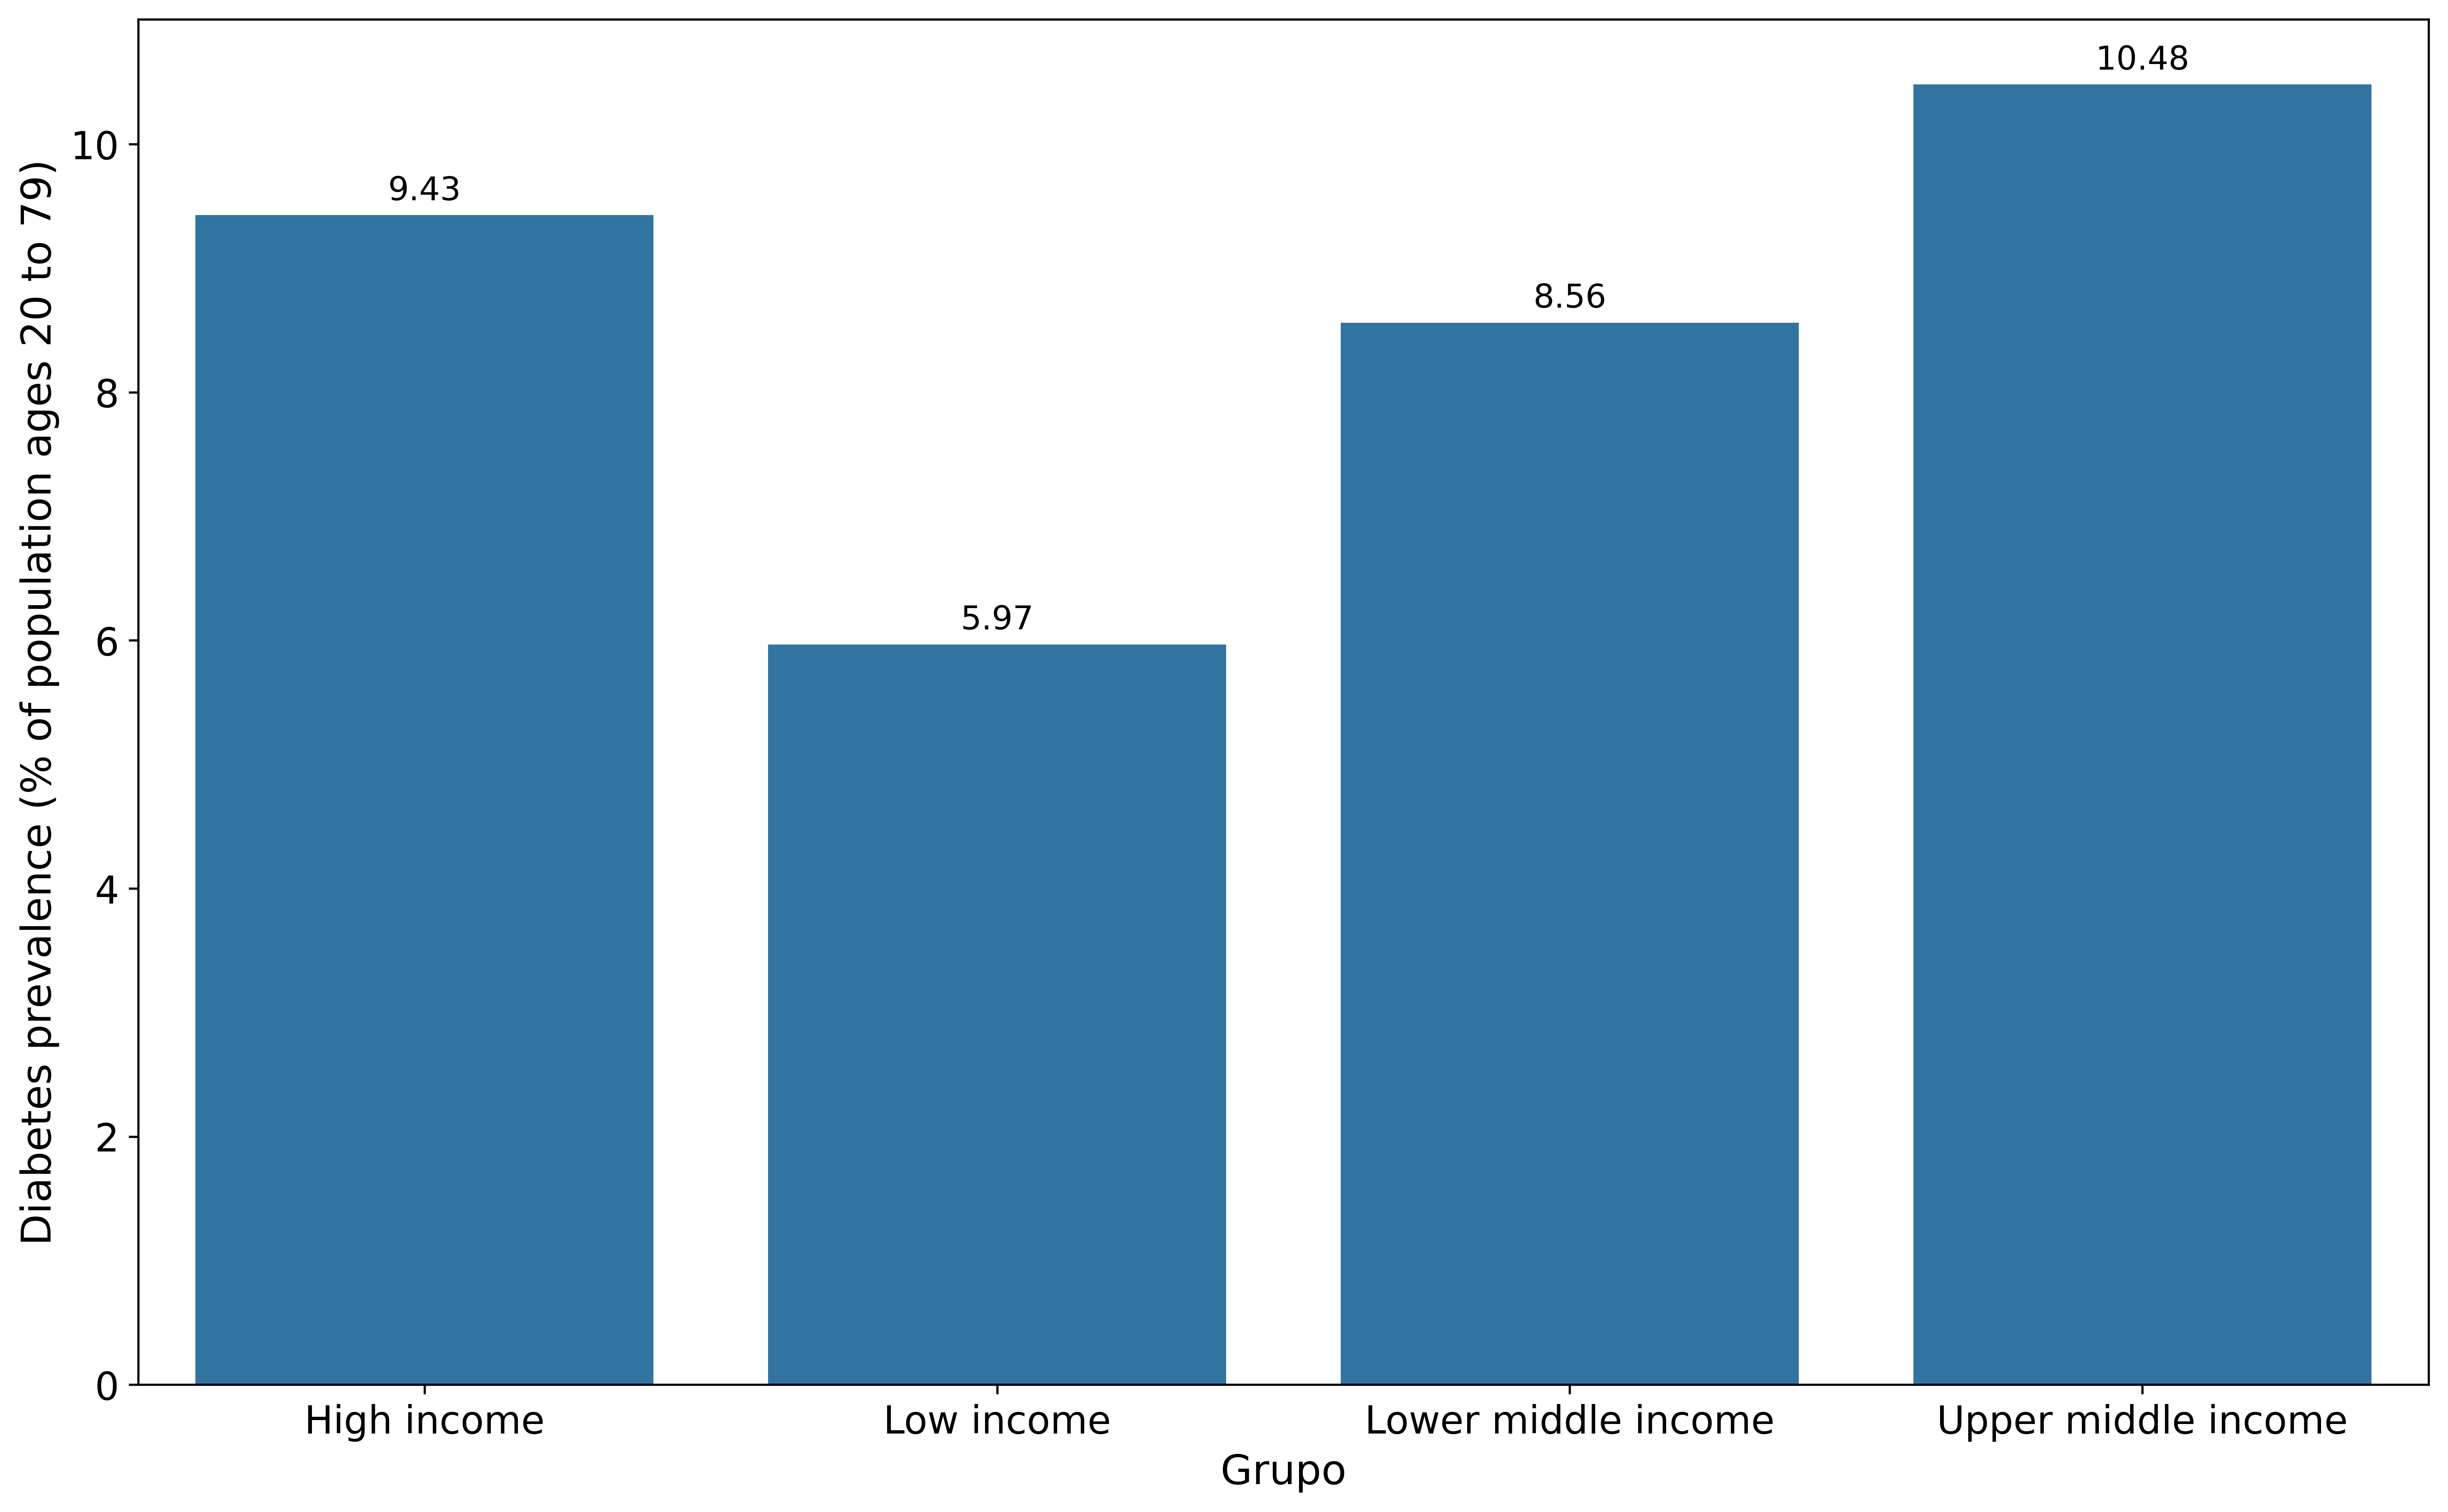

In [23]:
#%% Por exemplo, supondo que trata-se de um estudo sobre diabetes 

# Obter as posições das variáveis
col_pos = dados_saude.columns

# A variável de interesse está na posição 23

# Estatísticas descritivas
dados_saude.iloc[:,23].describe()

# Estatísticas por grupos
estat_grupo = dados_saude.iloc[:,[2,23]].groupby('Group').mean().reset_index()

# Finalizando com o gráfico
plt.figure(figsize=(15,9), dpi = 600)
ax = sns.barplot(data=estat_grupo, x=estat_grupo.iloc[:,0], y=estat_grupo.iloc[:,1])
for container in ax.containers: ax.bar_label(container, fmt='%.2f', padding=3, fontsize=12)
plt.xlabel('Grupo',fontsize=15)
plt.ylabel('Diabetes prevalence (% of population ages 20 to 79)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#%% FIM!